# Load data from [Street View House Numbers (SVHN) Dataset](http://ufldl.stanford.edu/housenumbers/)


In [1]:
%matplotlib inline

# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage,misc
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import h5py
import math

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Download data

In [2]:
url = 'http://ufldl.stanford.edu/housenumbers/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('train.tar.gz', 404141560)
test_filename = maybe_download('test.tar.gz', 276555967)
extra_filename = maybe_download('extra.tar.gz', 1955489752)

Found and verified train.tar.gz
Found and verified test.tar.gz
Found and verified extra.tar.gz


## Extract data

In [3]:
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  nb_files = len([
    file_name for file_name in sorted(os.listdir(root))
    if file_name.endswith(".png")])
  print("found %d image files in %s" % (nb_files,root))
  return root
  
train_folder = maybe_extract(train_filename)
test_folder = maybe_extract(test_filename)
extra_folder = maybe_extract(extra_filename)

train already present - Skipping extraction of train.tar.gz.
found 33402 image files in train
test already present - Skipping extraction of test.tar.gz.
found 13068 image files in test
extra already present - Skipping extraction of extra.tar.gz.
found 202353 image files in extra


## Display some images

displaying 2 sample images from folder train
6713.png


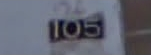

25667.png


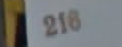

displaying 2 sample images from folder test
5312.png


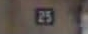

11708.png


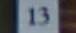

displaying 2 sample images from folder extra
40038.png


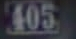

88604.png


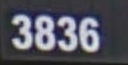

In [4]:
def display_sample_images(folder,to_display=5):
    print("displaying %d sample images from folder %s" %(to_display,folder))
    images=[file_name for file_name in sorted(os.listdir(folder)) 
            if file_name.endswith(".png")]
    for image in np.random.choice(images,to_display):
        print(image)
        display(Image(os.path.join(folder, image)))

display_sample_images(train_folder,2)
display_sample_images(test_folder,2)
display_sample_images(extra_folder,2)

## Load the data in a more manageable format

In [6]:
pixel_depth = 255.0  # Number of levels per pixel.
image_size = 64  # Pixel width and height.
num_channels=3
sub_image_size=54
max_labels=6
blanc_label=10

final_image_size=32
blanc_label=10

def display_image(image):
    plt.figure()
    plt.imshow(image)
    plt.show()

def expand(min_,max_,ratio,maximum):
    dist=math.ceil((max_-min_)*ratio)
    min_=int(min_-dist)
    max_=int(max_+dist)
    return max(min_,0),min(max_,maximum)

def load_folder(folder, min_num_images,to_add=0,max_num_images=None):
    """Load the data for a folder."""
    dataset= {}
    dataset['height'] = []
    dataset['label'] = []
    dataset['left'] = []
    dataset['top'] = []
    dataset['width'] = []
    dataset['image'] = []
    
    def print_attrs(name, obj):
        vals = []
        if obj.shape[0] == 1:
            vals.append(obj[0][0])
        else:
            for k in range(obj.shape[0]):
                vals.append(f[obj[k][0]][0][0])
        dataset[name].append(vals)
    
    image_files = sorted([file_name for file_name in os.listdir(folder)
                if file_name.endswith(".png")],
                         key=lambda name:int(name[:-4]))
    print ('first_images :')
    print(image_files[:10])
    total_images=len(image_files)
    num_images=0
    digitStruct_file = os.path.join(folder, "digitStruct.mat")
    with h5py.File(digitStruct_file,"r") as f:
        for item in f['/digitStruct/bbox']:
            f[item[0]].visititems(print_attrs)
            if num_images % 500 == 0:
                percent=num_images*100/total_images
                sys.stdout.write("%d%%" % percent)
                sys.stdout.flush()
            elif num_images % 50 == 0:
                sys.stdout.write(".")
                sys.stdout.flush()
            num_images=num_images+1
            if max_num_images!=None and num_images>=max_num_images:
                break
    
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' %
                        (num_images, min_num_images))
    
    print('loaded %d images'% len(dataset["label"]))
    print("resizing, reshaping and multiplying images")
    images = []
    labels = []
    
    def resize_and_add_image(label,image):
        #apply gray scale
        image= misc.imresize(image,(final_image_size, final_image_size,num_channels))        
        image=image.reshape(final_image_size, final_image_size,num_channels)
        
        labels.append(label)
        images.append(image)
    
    image_index=-1
    num_images=0
    for height,label,left,top,width in zip(
        dataset['height'],dataset['label'],dataset['left'],dataset['top'],dataset['width']):
        length=len(label)
        for i in range(length):
            if label[i]==blanc_label:
                label[i]=0
            while len(label)<max_labels:
                label.append(blanc_label)
        image_index = image_index+1
        image_file = os.path.join(folder, image_files[image_index])        
        try:
            image = (ndimage.imread(image_file).astype(float) - 
                          pixel_depth / 2) / pixel_depth
            resize_and_add_image(label,image)
        except IOError as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
            continue
        if to_add > 0:
            #print("original image")
            #display_image(image)
            #find out the minimum rectangle containing the digits            
            min_left=image.shape[1]
            min_top=image.shape[0]
            max_right=0
            max_bottom=0
            #print("initial ",min_top,max_bottom,min_left,max_right)
            for i in range(len(left)):
                min_left=min_left if min_left<=left[i] else left[i]
                min_top=min_top if min_top<=top[i] else top[i]
                right=left[i]+width[i]
                max_right=max_right if max_right>=right else right
                bottom=top[i]+height[i]
                max_bottom=max_bottom if max_bottom >= bottom else bottom
                
            #print("before expanding ",min_top,max_bottom,min_left,max_right)
            
            #expand the bounding box by 30%
            ratio=.30
            min_left,max_right=expand(min_left,max_right,ratio,image.shape[1])
            min_top,max_bottom=expand(min_top,max_bottom,ratio,image.shape[0])
            croped_image=image[min_top:max_bottom,min_left:max_right,:]            
            #print("cropped by ",min_top,max_bottom,min_left,max_right)
            #display_image(croped_image)
            resized_crop=misc.imresize(croped_image,(image_size, image_size,num_channels))
            size_diff=image_size-sub_image_size
            new_tops=np.random.choice(size_diff,to_add,replace=False)
            new_lefts=np.random.choice(size_diff,to_add,replace=False)
            for new_top,new_left in zip(new_tops,new_lefts):
                new_image=resized_crop[new_top:new_top+sub_image_size,new_left:new_left+sub_image_size,:]  
                #print("new image ")
                #display_image(new_image)
                #TODO also ajust the heights,widths,lefts and tops information
                resize_and_add_image(label,new_image)
        
        if image_index % 500 == 0:
            percent=image_index*100/total_images
            sys.stdout.write("%d%%" % percent)
            sys.stdout.flush()
        elif image_index % 50 == 0:
            sys.stdout.write(".")
            sys.stdout.flush()
        num_images+=1
    
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' %
                        (num_images, min_num_images))
    #shuffle the data
    #to_shuffle=zip(labels,images)
    #np.random.shuffle(to_shuffle)
    #labels,images=tuple([list(l) for l in zip(*to_shuffle)])
    #transorm image to np array
    print("transfoming to np array")
    images=np.asanyarray(images,dtype=np.float32)
    labels=np.asanyarray(labels,dtype=np.float32)
    dataset['label'] = labels
    dataset['image'] = images
    
    print("resized to %d: "%len(images))
    return dataset
        
def maybe_pickle(folder, min_num_images_per_class, force=False,to_add=0,max_num_images=None):
    set_filename = folder + '.pickle'
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
        print('Pickling %s.' % set_filename)
        dataset = load_folder(folder, min_num_images_per_class,to_add=to_add,max_num_images=max_num_images)
        with open(set_filename, 'wb') as f:
            print("saving data to ",set_filename)
            pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
    return set_filename

train_datasets = maybe_pickle(train_folder, 32000) #add no more new images, use extra folder instead
extra_datasets = maybe_pickle(extra_folder, 100000,max_num_images=100000)
test_datasets = maybe_pickle(test_folder, 12000)


train.pickle already present - Skipping pickling.
Pickling extra.pickle.
first_images :
['1.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png', '10.png']
0%.........0%.........0%.........0%.........0%.........1%.........1%.........1%.........1%.........2%.........2%.........2%.........2%.........3%.........3%.........3%.........3%.........4%.........4%.........4%.........4%.........5%.........5%.........5%.........5%.........6%.........6%.........6%.........6%.........7%.........7%.........7%.........7%.........8%.........8%.........8%.........8%.........9%.........9%.........9%.........9%.........10%.........10%.........10%.........10%.........11%.........11%.........11%.........11%.........12%.........12%.........12%.........12%.........13%.........13%.........13%.........13%.........14%.........14%.........14%.........14%.........15%.........15%.........15%.........15%.........16%.........16%.........16%.........16%.........17%.........17%.........17%......

## Display some labels and images to make sure that everything is loaded fine 

showing some labels and images for train.pickle
loaded 33402 images


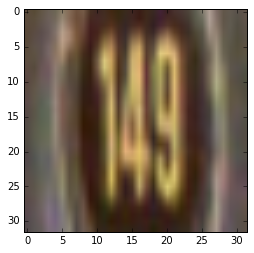

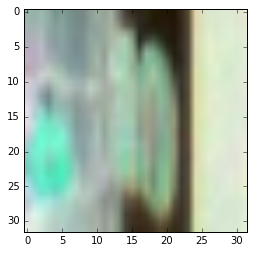

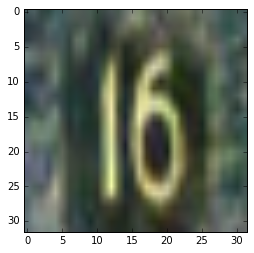

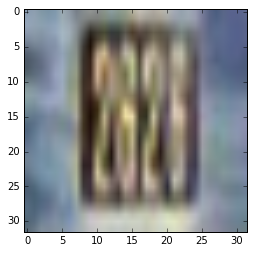

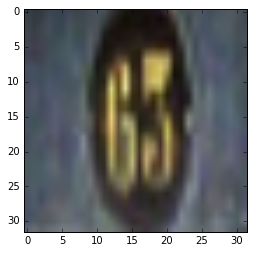

showing some labels and images for extra.pickle
loaded 100000 images


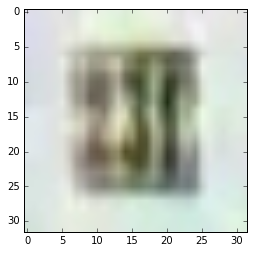

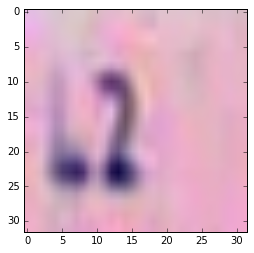

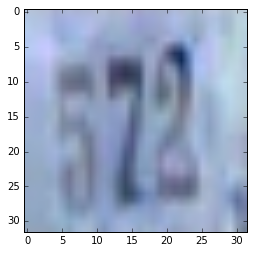

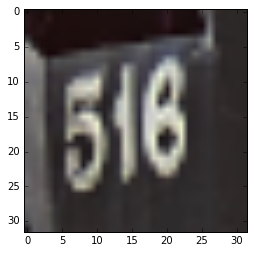

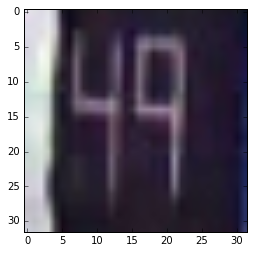

showing some labels and images for test.pickle
loaded 13068 images


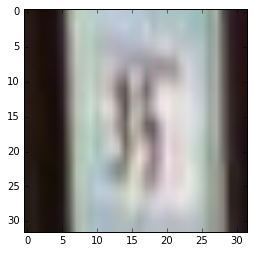

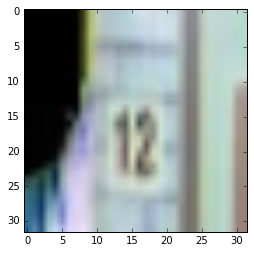

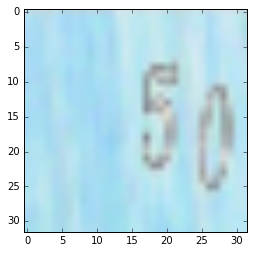

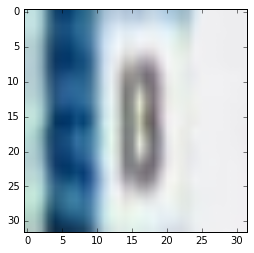

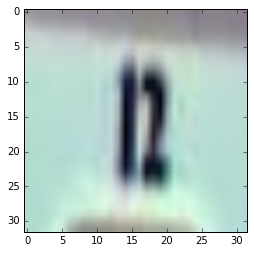

In [7]:
def display_images(file_name,num_images=5):
    print ("showing some labels and images for %s"%file_name)
    with open(file_name, 'r') as f:
        data=pickle.load(f)
        labels=data["label"]
        total_images=len(labels)
        images=data["image"]
        print("loaded %d images"%total_images)
        for i in np.random.choice(total_images-5,num_images,):
            display_image(images[i])
            
display_images(train_datasets)
display_images(extra_datasets)
display_images(test_datasets)